Instanciando la red pre-entrenada VGG16 para aplicarla a la BD de perros y gatos reducida (5000 imágenes) con expansión de imágenes pero esta vez con entonación fina

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


Accediendo a la BD de perros y gatos

In [ ]:
!pip install gdown #Instala una librería para descargar archivos de Google Drive
!gdown --id 1YeHqH7Gbypust6sZT2ehl8CUE9ELHQYC #Descarga el dataset que está en el Drive del Prof. Pereira
!unzip cats_vs_dogs_small.zip #Descomprime el archivo del dataset
from IPython.display import Image #Librería para visualizar imágenes en Jupyter
Image(filename='cats_vs_dogs_small/validation/cat/1488.jpg') #Visualiza el gato 1488
!cp cats_vs_dogs_small/train/Cat/665.jpg cats_vs_dogs_small/train/Cat/666.jpg
!cp cats_vs_dogs_small/train/Cat/834.jpg cats_vs_dogs_small/train/Cat/835.jpg

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: cats_vs_dogs_small/test/cat/1507.jpg  
  inflating: cats_vs_dogs_small/test/cat/1508.jpg  
  inflating: cats_vs_dogs_small/test/cat/1509.jpg  
  inflating: cats_vs_dogs_small/test/cat/1510.jpg  
  inflating: cats_vs_dogs_small/test/cat/1511.jpg  
  inflating: cats_vs_dogs_small/test/cat/1512.jpg  
  inflating: cats_vs_dogs_small/test/cat/1513.jpg  
  inflating: cats_vs_dogs_small/test/cat/1514.jpg  
  inflating: cats_vs_dogs_small/test/cat/1515.jpg  
  inflating: cats_vs_dogs_small/test/cat/1516.jpg  
  inflating: cats_vs_dogs_small/test/cat/1517.jpg  
  inflating: cats_vs_dogs_small/test/cat/1518.jpg  
  inflating: cats_vs_dogs_small/test/cat/1519.jpg  
  inflating: cats_vs_dogs_small/test/cat/1520.jpg  
  inflating: cats_vs_dogs_small/test/cat/1521.jpg  
  inflating: cats_vs_dogs_small/test/cat/1522.jpg  
  inflating: cats_vs_dogs_small/test/cat/1523.jpg  
  inflating: cats_vs_dogs_small/test/cat/1524.jpg  
  i

In [ ]:
new_base_dir=r"cats_vs_dogs_small"

In [ ]:
"""
import os, shutil
def make_subset(subset_name, start_index, end_index):
    for category in ("Cat", "Dog"):
        dir = new_base_dir+"/"+subset_name+"/"+category
        fnames = [f"{original_dir}/{category}/{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            print(fname)
            print(dir)
            shutil.copy(fname,dir)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)
"""

'\nimport os, shutil\ndef make_subset(subset_name, start_index, end_index):\n    for category in ("Cat", "Dog"):\n        dir = new_base_dir+"/"+subset_name+"/"+category\n        fnames = [f"{original_dir}/{category}/{i}.jpg" for i in range(start_index, end_index)]\n        for fname in fnames:\n            print(fname)\n            print(dir)\n            shutil.copy(fname,dir)\n\nmake_subset("train", start_index=0, end_index=1000)\nmake_subset("validation", start_index=1000, end_index=1500)\nmake_subset("test", start_index=1500, end_index=2500)\n'

Ajustando los datos de la BD de perros y gatos


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01))(x)
model = keras.Model(inputs, outputs)

Fijar los hiperparámetros y entrenar la red

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=50,  #30
    validation_data=validation_dataset)

Epoch 1/30
63/63 [==============================] - 30s 217ms/step - loss: 4.1366 - accuracy: 0.7385 - val_loss: 0.7912 - val_accuracy: 0.9230
Epoch 2/30
63/63 [==============================] - 12s 183ms/step - loss: 1.1016 - accuracy: 0.8675 - val_loss: 0.4345 - val_accuracy: 0.9450
Epoch 3/30
63/63 [==============================] - 12s 187ms/step - loss: 0.4974 - accuracy: 0.9165 - val_loss: 0.3009 - val_accuracy: 0.9610
Epoch 4/30
63/63 [==============================] - 12s 185ms/step - loss: 0.4198 - accuracy: 0.9180 - val_loss: 0.2632 - val_accuracy: 0.9610
Epoch 5/30
63/63 [==============================] - 12s 187ms/step - loss: 0.3511 - accuracy: 0.9340 - val_loss: 0.2376 - val_accuracy: 0.9590
Epoch 6/30
63/63 [==============================] - 12s 189ms/step - loss: 0.1697 - accuracy: 0.9525 - val_loss: 0.2293 - val_accuracy: 0.9640
Epoch 7/30
63/63 [==============================] - 12s 190ms/step - loss: 0.1539 - accuracy: 0.9550 - val_loss: 0.2027 - val_accuracy: 0.9620

Visualizando la pérdida y el accuracy durante el entrenamiento


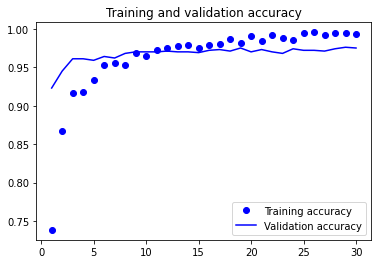

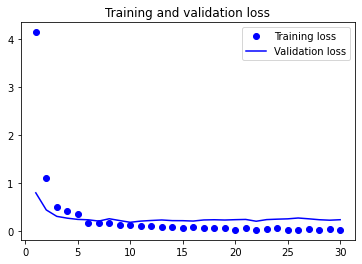

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Ejercicio:
---------

1. Revise los accuracy durante el entrenamiento para todas las mejoras que se han hecho a la BD de perros y gatos.
2. Pruebe con regularización y dropout ¿Qué obtiene?